In [153]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk import PorterStemmer
# import ipynb.fs.defs.TweetTextHandler as tweetTextHandler
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
# import plotly.offline as offline
# offline.init_notebook_mode(connected=True)

In [207]:
def replace_by_symbols(txt):
#     txt = re.sub(r"https\S+", 'URL', txt)
#     txt = re.sub(r"http\S+", 'URL', txt)
#     txt = re.sub(r"pic.twitter.com\S+", 'URL', txt)
#     txt = re.sub(r"twitter.com/\S+", 'URL', txt)
#     txt = re.sub(r"\S+/\S+", 'URL', txt)
#     txt = re.sub(r"@\S+", 'USERMENTION', txt)
#     txt = re.sub(r"#\S+", 'HASHTAG', txt)
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"\S+\'ll", '{0} will'.format(txt[0:-3]), txt)
    txt = re.sub(r"\S+\'ve", '{0} have'.format(txt[0:-3]), txt)
    return txt

In [172]:
def tokenize(text):
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(text)
#     stems = []
#     for item in tokens:
#         stems.append(PorterStemmer().stem(item))
    return tokens

In [114]:
def getWordsDict(texts):
    global stop_words
    wordDict = dict()
    stopwordDict = dict()
    stopwordTweetCount = 0
    tweet_length = 0
    tknzr = TweetTokenizer()
    aaa = texts
    length = len(texts)
    for txt in texts:
        stopwordFlag = False
        try:
            txt = filterMethods.filter_tweet_by_re(txt)
            tweet_length += len(txt)
            for token in tknzr.tokenize(txt):
                if token.isdigit():
                    pass
                elif token in stop_words:
                    stopwordDict[token] = stopwordDict.get(token, 0) + 1
                    stopwordFlag = True
                else:
                    wordDict[token] = wordDict.get(token, 0) + 1
            if stopwordFlag:
                stopwordTweetCount += 1
        except Exception as e:
            print(e)
    return wordDict, stopwordDict, stopwordTweetCount, round(tweet_length/length,1)

# Initialize Users

In [156]:
patients = dict()
ordinarys = dict()
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines()[:100]:
        patient = patient.strip()
        patients[patient] = peopleInfo.Patient(patient)
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = peopleInfo.Ordinary(ordinary)

# Filter Users

In [158]:
patients = filterMethods.filter_user_by_tweet_number(patients)
ordinarys = filterMethods.filter_user_by_tweet_number(ordinarys)

Remove users:[]
Remove users:[]


# Compare Stopwords between Ordinary People and Patients

In [159]:
patients_total = [0, 0, 0, 0]
for key in patients:
    _w, _s, _sc, _tl = getWordsDict(patients[key].getText())
    patients_total[0] += sum(_s.values())
    patients_total[1] += _sc
    patients_total[2] += len(patients[key].inRangeDf)
    patients_total[3] += _tl
    
patients_total[3] = round(patients_total[3]/len(patients),1)

# 0:Stopwords總數/ 1:含有stopwords的發文總數/ 2:（時間內的）發文總數/ 3:平均發文長度

In [160]:
ordinarys_total = [0, 0, 0, 0]
for key in ordinarys:
    _w, _s, _sc, _tl = getWordsDict(ordinarys[key].getText())
    ordinarys_total[0] += sum(_s.values())
    ordinarys_total[1] += _sc
    ordinarys_total[2] += len(ordinarys[key].inRangeDf)
    ordinarys_total[3] += _tl
    
ordinarys_total[3] = round(ordinarys_total[3]/len(ordinarys),1)
# 0:Stopwords總數/ 1:含有stopwords的推文總數/ 2:（時間內的）推文總數/ 3:平均發文長度

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



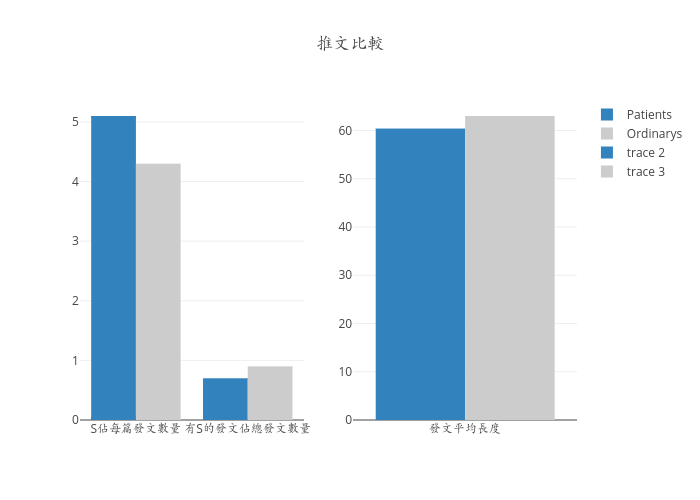

In [161]:
trace1_p = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                  y=[round(patients_total[0]/patients_total[1],1), round(patients_total[1]/patients_total[2],1)],
                  name='Patients',
                  marker=dict(color='rgb(49,130,189)'))

trace1_o = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                y=[round(ordinarys_total[0]/ordinarys_total[1],1), round(ordinarys_total[1]/ordinarys_total[2],1)],
                name='Ordinarys',
                marker=dict(color='rgb(204,204,204)'))

trace2_p = go.Bar(x=['發文平均長度'],
                y=[patients_total[3]],
                marker=dict(color='rgb(49,130,189)'))

trace2_o = go.Bar(x=['發文平均長度'],
                y=[ordinarys_total[3]],
                marker=dict(color='rgb(204,204,204)'))

fig = plotly.tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1_p,1,1)
fig.append_trace(trace1_o,1,1)
fig.append_trace(trace2_p,1,2)
fig.append_trace(trace2_o,1,2)
fig['layout'].update(title='推文比較')
# fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename='img/stopwords_compare.png')
display(Image(filename='img/stopwords_compare.png'))
# py.iplot(fig)

# Prepare Data

In [202]:
base_texts = []
group_texts = []

for key in patients.keys():
    group_texts.append(replace_by_symbols('\n'.join(patients[key].getText())))

for key in ordinarys.keys():
    base_texts.append(replace_by_symbols('\n'.join(ordinarys[key].getText())))

corpus = base_texts + group_texts

# TF-IDF Model with Multi-grams

In [203]:
def getTFIDF(base_texts, group_texts, grams, stop_words=True):
    print('Get Tf-idf with grams:{0}'.format(grams))
    low = grams[0]
    high = grams[1]
    text_model = dict()
    vectorizer = TfidfVectorizer(stop_words="english",ngram_range = (low,high), min_df=1)
    X = vectorizer.fit_transform(base_texts+group_texts)
    Y = np.array([0] * len(base_texts) + [1]*len(group_texts), dtype=int)
    text_model['X'] = X
    text_model['Y'] = Y
    text_model['vectorizer'] = vectorizer
    return text_model

In [204]:
def getTopFeatures(vectorizer, classifier, k=50):
    vector2word = vectorizer.get_feature_names()
    feature_indicies = np.argsort(classifier.feature_importances_)
    top_words = []
    for i in range(50):
        vector = feature_indicies[-i-1]
        word = vector2word[vector]
        top_words.append(word)
    return top_words

# Train RandomForest Classifier

In [205]:
grams = [[1,1],[1,2],[2,2]]
top_words_dict = {'Mix':[],'Base':[],'Group':[]}
for i in range(len(grams)):
    text_model = getTFIDF(base_texts, group_texts, grams=grams[i])
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifier.fit(text_model['X'],text_model['Y'])
    top_words = getTopFeatures(text_model['vectorizer'],classifier)
    top_words_dict['Mix'].append(top_words)

Get Tf-idf with grams:[1, 1]
Get Tf-idf with grams:[1, 2]
Get Tf-idf with grams:[2, 2]


In [206]:
top_words_dict['Mix']

[['depression',
  'diagnosed',
  'man',
  'die',
  'tried',
  'know',
  'living',
  'fuck',
  'sad',
  'worry',
  'lost',
  'falling',
  'honestly',
  'thank',
  'said',
  'looked',
  'gave',
  'blame',
  'issue',
  'wants',
  'thoughughts',
  'floor',
  'depressed',
  'clear',
  'worst',
  'trump',
  'heart',
  'oh',
  'step',
  'god',
  'longer',
  'care',
  'inside',
  'anxiety',
  'finally',
  'weekend',
  'sound',
  'let',
  'hours',
  'laughing',
  'attention',
  'think',
  'pain',
  'extra',
  'joke',
  'reply',
  'giving',
  'disorder',
  'control',
  'close'],
 ['diagnosed',
  'depression',
  'anxiety',
  'bed',
  'apple',
  'friend',
  'learned',
  'seen',
  'll',
  'truth',
  'kill',
  'tweet',
  'case',
  'hot',
  'months',
  'scream',
  'wild',
  'away',
  'pain',
  'care',
  'bad',
  'god',
  'thoughught',
  'finding',
  'gets',
  'fuck',
  'message',
  'giving',
  'parents',
  'higher',
  'suicide',
  'tbh',
  'drink',
  'read',
  'stress',
  '10',
  'drinking',
  'makes

In [137]:
for i in range(len(grams)):
    text_model = getTFIDF(base_texts, base_texts, grams=grams[i])
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifier.fit(text_model['X'],text_model['Y'])
    top_words = getTopFeatures(text_model['vectorizer'],classifier)
    top_words_dict['Base'].append(top_words)

Get Tf-idf with grams:[1, 1]
Get Tf-idf with grams:[1, 2]
Get Tf-idf with grams:[2, 2]


In [138]:
for i in range(len(grams)):
    text_model = getTFIDF(group_texts, group_texts, grams=grams[i])
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifier.fit(text_model['X'],text_model['Y'])
    top_words = getTopFeatures(text_model['vectorizer'],classifier)
    top_words_dict['Group'].append(top_words)

Get Tf-idf with grams:[1, 1]
Get Tf-idf with grams:[1, 2]
Get Tf-idf with grams:[2, 2]


# Top 50: Unigram

In [147]:
unigram = pd.DataFrame(np.column_stack([top_words_dict['Mix'][0], top_words_dict['Base'][0], top_words_dict['Group'][0]]), columns=['Mix', 'Base', 'Group'])

In [148]:
unigram

,Mix,Base,Group
0,depression,lo,man
1,diagnosed,thanks,hurting
2,sorry,want,sucks
3,ner,ll,hit
4,life,did,having
5,telling,got,sleeping
6,honestly,ner,ship
7,bad,vote,going
8,depressed,really,delete
9,eryone,people,agree


# Top 50: Unigram and Bigrams

In [149]:
uni_bi_gram = pd.DataFrame(np.column_stack([top_words_dict['Mix'][1], top_words_dict['Base'][1], top_words_dict['Group'][1]]), columns=['Mix', 'Base', 'Group'])

In [150]:
uni_bi_gram

,Mix,Base,Group
0,diagnosed,lo,lo
1,care,thanks,better
2,sorry,party,kill
3,good,getting,tired
4,deser,want,grown
5,god,girl,facetime
6,note,time,picture
7,anxiety,good,liberal
8,ha idea,speaking,simply
9,walking,daughter thingy,small


# Top 50: Bigrams

In [151]:
bigram = pd.DataFrame(np.column_stack([top_words_dict['Mix'][2], top_words_dict['Base'][2], top_words_dict['Group'][2]]), columns=['Mix', 'Base', 'Group'])

In [152]:
bigram

,Mix,Base,Group
0,diagnosed depression,vote speaking,does note
1,ha does,lo mother,best day
2,does need,want vote,did watch
3,does know,daughter thingy,lo yes
4,people ha,does note,day just
5,just want,mother daughter,read book
6,long time,let know,know en
7,look like,little bitch,need stop
8,holy shit,hardcore gamers,gonna make
9,does like,hope good,know feel


# Get Precision

In [111]:
def getPrecision(base_texts, group_texts, text_model, clf = "default", n_fold=10):
    X = text_model['X']
    Y = text_model['Y']
    sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
    if clf == 'default':
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        
    precisions = []
    for train_index, test_index in sss:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        classifier = classifier.fit(X_train, Y_train)
        score = classifier.score(X_test, Y_test)
        precisions.append(score)
    return precisions

In [112]:
precisions = getPrecision(base_texts,group_texts,text_model)

In [113]:
np.mean(precisions)

0.76315789473684204

# Stopwords Pattern

In [116]:
with open ('stopwords_pattern_group', 'a') as open_file:
    tknzr = TweetTokenizer()
    pattern_position = dict()
    for txts in group_texts:
        for txt in txts.split('\n'):
            position = []
            for i, word in enumerate(replace_by_symbols(txt)):
                if word in stop_words:
                    position.append(i)
            open_file.write('{0}\n'.format(position))

In [117]:
with open ('stopwords_pattern_base', 'a') as open_file:
    tknzr = TweetTokenizer()
    pattern_position = dict()
    for txts in base_texts:
        for txt in txts.split('\n'):
            position = []
            for i, word in enumerate(replace_by_symbols(txt)):
                if word in stop_words:
                    position.append(i)
            open_file.write('{0}\n'.format(position))

In [118]:
swg = dict()
swg_len = 0
with open ('stopwords_pattern_group') as open_file:
    for line in open_file.readlines():
        swg_len += 1
        a = list(line.strip()[1:-1].split(', '))
        for i in range(len(a)):
            try:
                difference = abs(int(a[i]) - int(a[i+1]))
                swg[difference] = swg.get(difference, 0) + 1 
            except (IndexError, ValueError) as e:
#                 if e.args[0] == "invalid literal for int() with base 10: ''":
#                     print(line)
                continue

In [119]:
swb = dict()
swb_len = 0
with open ('stopwords_pattern_base') as open_file:
    for line in open_file.readlines():
        swb_len += 1
        a = list(line.strip()[1:-1].split(', '))
        for i in range(len(a)):
            try:
                difference = abs(int(a[i]) - int(a[i+1]))
                swb[difference] = swb.get(difference, 0) + 1 
            except (IndexError, ValueError) as e:
                continue

In [138]:
for key in swb.keys():
    swb[key] = swb[key]/swb_len
sorted_swb = sorted(swb.items(), key=operator.itemgetter(1), reverse=True)

for key in swg.keys():
    swg[key] = swg[key]/swg_len
sorted_swg = sorted(swg.items(), key=operator.itemgetter(1), reverse=True)

In [157]:
trace11 = go.Bar(
    x=[ele[0] for ele in sorted_swb[:10]],
    y=[ele[1] for ele in sorted_swb[:10]],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)'))

trace22 = go.Bar(
    x=[ele[0] for ele in sorted_swg[:10]],
    y=[ele[1] for ele in sorted_swg[:10]],
    name='Patient',
    marker=dict(color='rgb(49,130,189)'))

fig12 = plotly.tools.make_subplots(rows=1, cols=2)
fig12.append_trace(trace22,1,1)
fig12.append_trace(trace11,1,2)
py.iplot(fig12)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [154]:
trace1 = go.Bar(
    x=[ele[0] for ele in sorted_swb[:10]],
    y=[abs(1/math.log(ele[1])) for ele in sorted_swb[:10]],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)')
)
trace2 = go.Bar(
    x=[ele[0] for ele in sorted_swg[:10]],
    y=[abs(1/math.log(ele[1])) for ele in sorted_swg[:10]],
    name='Patient',
    marker=dict(color='rgb(49,130,189)')
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# Finder

In [109]:
def finder(matcher, group):
    pattern = re.compile(r"{0}".format(matcher))
    if group == 'group':
        texts = group_texts
    else:
        texts = base_texts
    for i, txts in enumerate(texts):
        for txt in txts.split('\n'):
            if pattern.match(txt):
                print('[{0}] {1}'.format(i, txt))
                

In [208]:
finder('tbh','group')

[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis for a penny polony
[20] tbh I lis

[38] tbh i'm feeling a lot better than i thoughught i would this first week of low-carb eating. maybe the tiredness just blends w my depression.
[38] tbh suits of armor improve most things by minimum 30%
[38] tbh the greyed-out text under the username is fucking with me?? i keep thinking it's a link  already clicked
[38] tbh it could literally just be a book jacket around a dvd of you and  telling bad jokes and i would 100% buy it
[38] tbh that's one reason  been avoiding buying a cintiq even thoughugh i know it will help me draw more efficiently
[38] tbh i kind of want to mail you two some stuff as a thank you for making such great books. Vol 1 made me happy cry.
[38] tbh i'm feeling a lot better than i thoughught i would this first week of low-carb eating. maybe the tiredness just blends w my depression.
[38] tbh suits of armor improve most things by minimum 30%
[38] tbh the greyed-out text under the username is fucking with me?? i keep thinking it's a link  already clicked
[38] tbh 

[56] tbh it's me whenever I see a cute guy
[56] tbh the only thing better than making a spreader back down, is watching two spreaders battle for dominance    …
[56] tbh I learnt it from a pub quiz lmao    …
[56] tbh who knows how they'll clean it up? your guess is as good as mine
[56] tbh I would have written a normal essay, and another one on heterotopias, and proceed to submit my normal essay late anyway
[56] tbh there's so many of them, I do not expect anybody but a psychiatrist to know all of them and their characteristics
[56] tbh it's me whenever I see a cute guy
[56] tbh the only thing better than making a spreader back down, is watching two spreaders battle for dominance    …
[56] tbh I learnt it from a pub quiz lmao    …
[56] tbh who knows how they'll clean it up? your guess is as good as mine
[56] tbh I would have written a normal essay, and another one on heterotopias, and proceed to submit my normal essay late anyway
[56] tbh there's so many of them, I do not expect anybody

In [215]:
group_texts

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
